In [1]:
import pyprojroot
import sys

package_path = pyprojroot.here().__str__()
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
import re
import os
import pickle
import mlflow
import mlflow.sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import LoadData, AbsPaths

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Loading and prepare data

In [3]:
final_data='operational_rdbms.csv'
df = LoadData().from_csv(file_name=final_data)
df.loc[:,'tourney_name']=df.tourney_name.str.upper() ###AGREGAR A CALIDAD DE DATOS.

In [4]:
df.head()

,tourney_date,tourney_name,surface,id,ht,wg,age,rank,minutes_played,pj,pg,pp,round
0,2000-01-17,AUSTRALIAN OPEN,Hard,101086.0,180.0,82.0,36,94.0,0.0,0.0,0.0,0.0,128
1,2000-01-17,AUSTRALIAN OPEN,Hard,101150.0,180.0,80.0,35,82.0,0.0,0.0,0.0,0.0,64
2,2000-01-17,AUSTRALIAN OPEN,Hard,101185.0,188.0,88.0,35,126.0,0.0,0.0,0.0,0.0,64
3,2000-01-17,AUSTRALIAN OPEN,Hard,101463.0,185.0,73.0,32,139.0,0.0,0.0,0.0,0.0,128
4,2000-01-17,AUSTRALIAN OPEN,Hard,101532.0,183.0,71.0,32,39.0,0.0,0.0,0.0,0.0,32


In [5]:
def one_hot_codification(data:pd.DataFrame, variable:str):

    new_variables= pd.get_dummies(data[variable], drop_first=True)
    data.loc[:,new_variables.columns]=new_variables
    data=data.drop(columns=variable)
    #data=pd.concat([data.drop(columns=variable),new_variables],axis=1)
    return data

In [6]:
def ordinal_codification(data:pd.DataFrame, variable:str):

    for i,j in enumerate(np.sort(df[variable].unique())):
        data.loc[data[variable]==j,variable+'_cod']=i
    
    data=data.drop(columns=variable)
    return data

In [7]:
def config_inputs(data, nominal_variables=None, ordinal_variables=None):
    if nominal_variables==None:
        nominal_variables=['surface', 'tourney_name']#,'id']
    if ordinal_variables==None:
        ordinal_variables=['round','tourney_date','id']
    for i in nominal_variables:
        data=one_hot_codification(data, i)
    for i in ordinal_variables:
        data=ordinal_codification(data,i)

    data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower().replace(' ', '_') for col in data.columns.str.lower()]
    return data

In [8]:
df2=config_inputs(df)

C:\Users\johnm\AppData\Local\Temp\ipykernel_18280\3377404753.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables
C:\Users\johnm\AppData\Local\Temp\ipykernel_18280\3377404753.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables


In [9]:
df2.head()

,ht,wg,age,rank,minutes_played,pj,pg,pp,grass,hard,roland_garros,us_open,wimbledon,round_cod,tourney_date_cod,id_cod
0,180.0,82.0,36,94.0,0.0,0.0,0.0,0.0,0,1,0,0,0,6.0,0.0,1.0
1,180.0,80.0,35,82.0,0.0,0.0,0.0,0.0,0,1,0,0,0,5.0,0.0,2.0
2,188.0,88.0,35,126.0,0.0,0.0,0.0,0.0,0,1,0,0,0,5.0,0.0,3.0
3,185.0,73.0,32,139.0,0.0,0.0,0.0,0.0,0,1,0,0,0,6.0,0.0,5.0
4,183.0,71.0,32,39.0,0.0,0.0,0.0,0.0,0,1,0,0,0,4.0,0.0,6.0


# Training model

In [10]:
def make_train_test_split(x, y, test_size = 0.25, random_state = 42):

    (x_train, x_test, y_train, y_test) = train_test_split(
        x,
        y,
        test_size=test_size,
        random_state=random_state,
    )
    return x_train, x_test, y_train, y_test

In [11]:
def eval_metrics(y_true, y_pred, y_preb_probs, 
                 labels = None):

    class_report = classification_report(y_true, y_pred, labels=labels)
    roc_auc_score_ = roc_auc_score(y_true, y_preb_probs, average="weighted", multi_class="ovr")
    print(roc_auc_score)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return class_report, roc_auc_score_, mse, mae, r2


In [12]:
def report(estimator, class_report, roc_auc_score_, mse, mae, r2):
    print(estimator, ":", sep="")
    print(f"Classification report: \n {class_report}")
    print(f"  ROC AUC score: {roc_auc_score_}")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R2: {r2}")


In [13]:
# -----------------------------------------------------------------------------
# Ya no se requiere con MLflow
# -----------------------------------------------------------------------------
# def save_best_estimator(estimator, 
#                         estimator_name='estimator.pkl',
#                         models_path=None 
#                         ):

#     if models_path is None:
#         try:
#             models_path = AbsPaths().get_abs_path_folder('models')
#         except:
#             models_path = AbsPaths().parent_path+os.sep+'models'
#             os.makedirs(models_path)

#     with open(models_path+estimator_name, "wb") as file:
#         pickle.dump(estimator, file)

In [14]:
# -----------------------------------------------------------------------------
# Ya no se requiere con MLflow
# -----------------------------------------------------------------------------

def load_best_estimator(estimator_name='estimator.pkl'):
    try:
        estimator_path = AbsPaths().get_abs_path_file(estimator_name)
    except:
        return None
    
    with open(estimator_path, 'rb') as fp:
        estimator = pickle.load(fp)
        return estimator


In [20]:
def train_estimator(param_grid, x, y,
                    n_iter=5, 
                    n_splits=5, 
                    verbose=1, 
                    path_img=None, 
                    class_names=None):

    x_train, x_test, y_train, y_test = make_train_test_split(x=x, y=y)

    # ------------------------------------------------
    # Búsqueda de parámtetros con validación cruzada

    estimator = RandomizedSearchCV(
        estimator=RandomForestClassifier(
            random_state = 42,
        ),
        param_distributions = param_grid,
        n_iter = n_iter,
        cv = n_splits,
        refit = True,
        verbose = 0 
    )

    # ------------------------------------------------
    estimator.fit(x_train, y_train)

    estimator = estimator.best_estimator_

    class_report, roc_auc_score_, mse, mae, r2 = eval_metrics(y_true=y_test,
                                                              y_pred=estimator.predict(x_test),
                                                              y_preb_probs=estimator.predict_proba(x_test))

    
    if verbose > 0 :
        report(estimator, class_report, roc_auc_score_, mse, mae, r2)

    if class_names is None:
        class_names = y_train.unique()

    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        estimator,
        x_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=None,
        )
    
    if path_img is None:
        try:
            path_img=AbsPaths().get_abs_path_folder(folder_name='figures')
        except:
            path_img = AbsPaths().parent_path+os.sep+'figures'
            os.makedirs(path_img)
    
    plt.savefig(path_img + 'confusion_matrix.png')
    plt.show()

    # Setting tracking of mlflow in models folder
    try:
        models_path = AbsPaths().get_abs_path_folder('models')
    except:
        models_path = AbsPaths().parent_path+os.sep+'models'
        os.makedirs(models_path)
    
    mlflow.set_tracking_uri(f"file:{models_path}"+"mlruns")

    with mlflow.start_run():
        
        # Log params
        params = estimator.get_params()
        
        mlflow.log_param('class_weight', params['class_weight'])
        mlflow.log_param('criterion', params['criterion'])
        mlflow.log_param('max_depth', params['max_depth'])
        mlflow.log_param('n_estimators', params['n_estimators'])

        # Log some metrics
        mlflow.log_metric('roc_auc_score', roc_auc_score_)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # Log model
        mlflow.sklearn.log_model(estimator, "model")

        # Log an artifac
        plain_text_path = AbsPaths().get_abs_path_folder('plain-text')
        with open(plain_text_path+'evaluation.txt', "w") as f:
            print(class_report, file=f)

        mlflow.log_artifacts(plain_text_path)

        mlflow.log_artifact(AbsPaths().get_abs_path_folder('figures'))

        



In [25]:
 print(mlflow.get_tracking_uri())

file:c:\Users\johnm\Desktop\predict-roland-garros-positions\models\mlruns


In [21]:
param_grid = { 
    'n_estimators': [100, 200, 250, 500],
    # 'max_features': ['sqrt', 'log2'],
    # 'min_samples_split': np.arange(2,16,2),
    'max_depth' : np.arange(1,28,4),
    'criterion' :['gini', 'entropy','log_loss'],
    'class_weight':['balanced', 'balanced_subsample']
}

In [22]:
class_names=list(map(lambda x: 'R-'+str(x) , list(sorted(set(df['round'])))))
class_names

['R-1', 'R-2', 'R-4', 'R-16', 'R-32', 'R-64', 'R-128']

<function roc_auc_score at 0x00000278BAC8EE60>
RandomForestClassifier(class_weight='balanced', max_depth=17, n_estimators=500,
                       random_state=42):
Classification report: 
               precision    recall  f1-score   support

         0.0       0.43      0.36      0.39        36
         1.0       0.12      0.05      0.08        37
         2.0       0.05      0.03      0.04        74
         3.0       0.16      0.14      0.15       117
         4.0       0.27      0.17      0.21       258
         5.0       0.25      0.10      0.14       544
         6.0       0.60      0.86      0.70      1142

    accuracy                           0.50      2208
   macro avg       0.27      0.24      0.24      2208
weighted avg       0.42      0.50      0.44      2208

  ROC AUC score: 0.6616699669855098
  MSE: 1.6268115942028984
  MAE: 0.7762681159420289
  R2: 0.10679450702118887


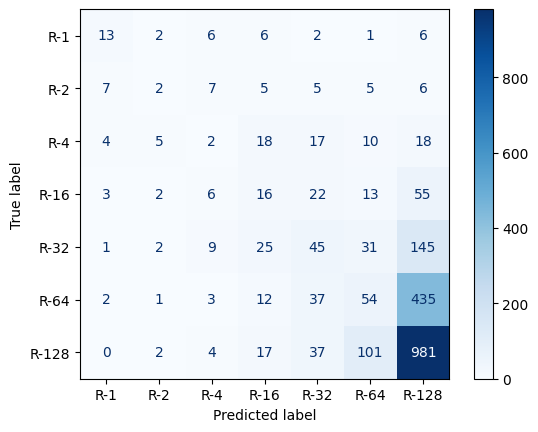

file:['c:\\Users\\johnm\\Desktop\\predict-roland-garros-positions\\models\\', 'c:\\Users\\johnm\\Desktop\\predict-roland-garros-positions\\notebooks\\develop\\mlruns\\models\\']mlruns
file:c:\Users\johnm\Desktop\predict-roland-garros-positions\models\mlruns


In [24]:
x=df2.drop(columns='round_cod')
y=df2.round_cod

train_estimator(
    param_grid=param_grid,
    x=x,
    y=y,
    class_names=class_names,
    n_splits=5,
    verbose=1
)

<function roc_auc_score at 0x00000278BAC8EE60>
RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                       n_estimators=250, random_state=42):
Classification report: 
               precision    recall  f1-score   support

         0.0       0.45      0.42      0.43        36
         1.0       0.10      0.05      0.07        37
         2.0       0.11      0.04      0.06        74
         3.0       0.15      0.11      0.13       117
         4.0       0.26      0.16      0.19       258
         5.0       0.20      0.07      0.10       544
         6.0       0.58      0.87      0.70      1142

    accuracy                           0.50      2208
   macro avg       0.27      0.25      0.24      2208
weighted avg       0.40      0.50      0.43      2208

  ROC AUC score: 0.652870854585054
  MSE: 1.7346014492753623
  MAE: 0.7980072463768116
  R2: 0.047612183154552734


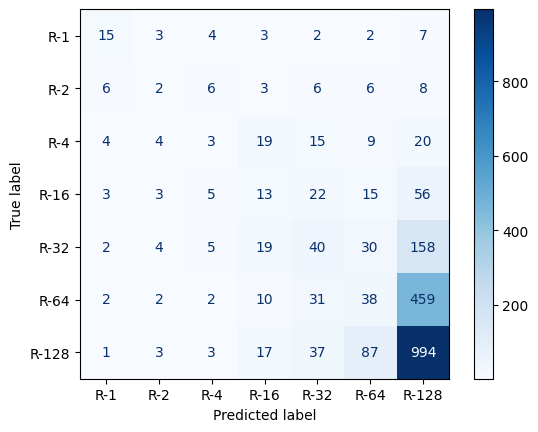

In [19]:
x=df2.drop(['round_cod', 'id_cod'], axis=1)
y=df2['round_cod']

train_estimator(
    param_grid=param_grid,
    x=x,
    y=y,
    class_names=class_names,
    n_splits=5,
    verbose=1
)